# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from typing import Final
import pandas as pd
import dataclasses
from etils import epath
import torch_scatter
import gc
from tqdm.notebook import tqdm
from graphmodels import featurizer, constants, datasets, data_utils, models, layers
from torch.utils.data import DataLoader, Dataset
from sklearn import model_selection as sk_modelselection
from sklearn import metrics as sk_metrics
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [14]:
layers

AttributeError: module 'graphmodels.layers' has no attribute 'mpnn_layers'

In [2]:
DATAPATH: epath.Path = epath.Path("../datasets/chemistry/")
df = pd.read_csv(DATAPATH/"delaney-processed_clean.csv")
df["mol"] = df["RDKIT_SMILES"].apply(Chem.MolFromSmiles)
df["num_bonds"] = df["mol"].apply(lambda x : x.GetNumBonds())
df = df.loc[df["num_bonds"]>=1]

In [3]:
# Split data
train_df, test_df = sk_modelselection.train_test_split(
    df, test_size=0.2, random_state=42, shuffle=True,
    #stratify=df["measured log solubility in mols per litre"]
)
train_df, valid_df = sk_modelselection.train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    #stratify=train_df["measured log solubility in mols per litre"],
)

In [4]:
LABEL: str = "measured log solubility in mols per litre"
SMILES: str = "smiles"
train_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(train_df[SMILES]),
                                               targets=tuple(train_df[LABEL]),
                                 add_master_node=False)

valid_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(valid_df[SMILES]),
                                               targets=tuple(valid_df[LABEL]),
                                 add_master_node=False)

test_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(test_df[SMILES]),
                                               targets=tuple(test_df[LABEL]),
                                add_master_node=False)


train_dataloader = DataLoader(dataset=train_dset,
                              batch_size=64,
                              shuffle=True,
                              collate_fn=data_utils.mpnn_collate_diag,
                             )

valid_dataloader = DataLoader(dataset=valid_dset,
                              batch_size=32,
                              shuffle=False,
                              collate_fn=data_utils.mpnn_collate_diag,
                             )

test_dataloader = DataLoader(dataset=test_dset,
                              batch_size=32,
                              shuffle=False,
                              collate_fn=data_utils.mpnn_collate_diag,
                            )

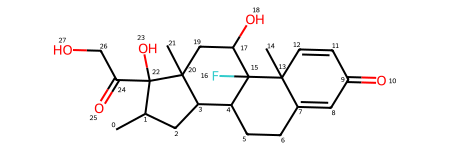

In [5]:
i=80
element = train_dset[i]
element_smiles = train_df[SMILES].iloc[i]
mol = Chem.MolFromSmiles(element_smiles)

mol

In [6]:
node_features = element.node_features
edge_features = element.edge_features
edge_index = element.edge_indices

j_nodes = edge_index[1]
i_nodes = edge_index[0]

In [7]:
edge_features.shape

torch.Size([31, 24])

In [8]:
node_features.shape

torch.Size([28, 136])

# Graph attention mechanism

In [9]:

n_f = 512

W = nn.Linear(node_features.size(-1), node_features.size(-1))

h = W(node_features)

h_j = h[j_nodes]
h_i = h[i_nodes]

A = nn.Linear(node_features.size(-1)*2, 1)

h_concat = torch.cat([h_i, h_j], dim=-1)

eij = A(h_concat)

eij_normalized = torch_scatter.scatter_softmax(src=eij, index=i_nodes, dim=0)

eij_normalized.shape

torch.Size([31, 1])

## Multihead attention

In [10]:
# k = 8
# n_h = 64

# dk = 512


# scaling = 0.2

# multihead_w = nn.Linear(node_features.size(-1), dk)
# multihead_a = nn.Linear(dk*2, dk)

# h = F.leaky_relu(multihead_attn_layer(node_features), scaling)
# neighbors_nodes = edge_index[1]
# target_nodes = edge_index[0]

# h_i = h[target_nodes]
# h_j = h[neighbors_nodes]


# h_concat = torch.cat([h_i, h_j], dim=-1)

# eij = multihead_a(h_concat)

# alpha = torch_scatter.scatter_softmax(src=eij, index=target_nodes, dim=0)

# res = alpha*h_j

In [11]:


# h = F.leaky_relu(self.w(node_features), self.scaling)

# neighbors_nodes = edge_index[1]
# target_nodes = edge_index[0]

# h_i = h[target_nodes]
# h_j = h[neighbors_nodes]

# h_concat = torch.cat([h_i, h_j], dim=-1)

# eij = self.attn(h_concat)

# eij_normalized = torch_scatter.scatter_softmax(src=eij, index=target_nodes, dim=0)

# res = eij_normalized*h_j

# out = torch.zeros_like(h)

# out = out.index_add(0, target_nodes, res)

# out = F.leaky_relu(out, self.scaling)

# return out

In [12]:
class SimpleGATModel(nn.Module):
    """Implements a simple graph attention model."""
    def __init__(self, n_node_features: int, n_hidden_features: int, n_out_features: int, scaling: float=0.2):
        super().__init__()
        self.gat_layer1 = layers.graph_attention_layers.SimpleGAT(n_node_features, n_hidden_features, scaling)
        self.gat_layer2 = layers.graph_attention_layers.SimpleGAT(n_hidden_features, n_hidden_features, scaling)
        self.gat_layer3 = layers.graph_attention_layers.SimpleGAT(n_hidden_features, n_hidden_features, scaling)
        self.output_layer = nn.Linear(n_hidden_features, n_out_features)
        
    def forward(self, x):
        node_features, edge_index, batch_vector = x
        
        x_gat = (node_features, edge_index)
        
        out1 = self.gat_layer1((node_features, edge_index))
        

        out2 = self.gat_layer2((out1, edge_index))

        out3 = self.gat_layer3((out2, edge_index))
        
        num_batches = int(batch_vector.max()) + 1
        
        emb_dim = out3.size(-1)
        
        mol_embeddings = torch.zeros(
            num_batches, emb_dim, device=out3.device
        )

        mol_embeddings.index_add_(0, batch_vector, out3)
        
        return self.output_layer(mol_embeddings)
        

In [13]:
layers.graph_attention_layers

AttributeError: module 'graphmodels.layers' has no attribute 'graph_attention_layers'

In [ ]:
def train_model(model,
                train_loader,
                valid_loader,
                loss_fn,
                epochs=10,
                lr=1e-3,
                device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    model.to(device)
    print("🚀 Starting training...\n")
    pbar = tqdm(total=epochs, desc="Training")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            atom_feats = batch.node_features.to(device)
            #bond_features =  batch.edge_features.to(device)
            edge_index = batch.edge_index.to(device)
            labels = batch.targets.to(device)
            batch_vector = batch.batch_vector.to(device)

            optimizer.zero_grad()
            outputs = model((atom_feats, edge_index, batch_vector)).squeeze()

            loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                atom_feats = batch.node_features.to(device)
                #bond_features =  batch.edge_features.to(device)
                edge_index = batch.edge_index.to(device)
                labels = batch.targets.to(device)
                batch_vector = batch.batch_vector.to(device)

                outputs = model((atom_feats, edge_index, batch_vector)).squeeze()
                loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)

        # Update the tqdm progress bar with train and validation loss
        pbar.set_postfix({"train_loss": f"{train_loss:.4f}", "val_loss": f"{valid_loss:.4f}"})

        history.append({'epoch': epoch+1, 'train_loss': train_loss, 'valid_loss': valid_loss})
        pbar.update(1)

    pbar.close()
    print("\n🎉 Training completed!\n")
    return pd.DataFrame(history)


In [ ]:
gat_model = SimpleGATModel(136, 512, 1)
history = train_model(model=gat_model,
                      loss_fn=nn.MSELoss(),
                      train_loader=train_dataloader,
                      valid_loader=valid_dataloader,
                      epochs=10,
                      lr=5e-3,
                      device="cuda")

gc.collect()
torch.cuda.empty_cache()

In [ ]:
ax = sns.lineplot(history, x="epoch", y="train_loss",color="green")
ax = sns.lineplot(history, x="epoch", y="valid_loss", color="orange")

In [ ]:
gat_model.eval()
device="cpu"
gat_model.to(device)

preds = []
target_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        
        atom_feats = batch.node_features.to(device)
        bond_features =  batch.edge_features.to(device)
        edge_index = batch.edge_index.to(device)
        labels = batch.targets.to(device)
        batch_vector = batch.batch_vector.to(device)

        outputs = gat_model((atom_feats, edge_index, batch_vector)).squeeze()
        preds.append(outputs)
        target_labels.append(labels)

preds = torch.cat(preds)
target_labels = torch.cat(target_labels)

In [ ]:

rmse = np.sqrt(sk_metrics.mean_squared_error(target_labels, preds))
print(f"RMSE = {rmse}")
